# Auto-Encoder for Iris Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib.colors import ListedColormap

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [3]:
iris = datasets.load_iris()
X = iris.data
t = iris.target
target_names = iris.target_names

print('Size of the data = ', X.shape)
n = X.shape[0]
mdim = X.shape[1]
print('N=', n, 'mdim=', mdim)
print('size of t', t.shape)

# normarize X
xmean = np.mean(X, axis=0)
xsd = np.std(X, axis=0)
X = (X - xmean)/xsd
print(X)

X = torch.tensor(X, dtype=torch.float32)
t = torch.tensor(t, dtype=torch.int64)

print(X.shape, t.shape)  # 出力: (150, 4) (150,)

print(type(X))

Size of the data =  (150, 4)
N= 150 mdim= 4
size of t (150,)
[[-9.00681170e-01  1.01900435e+00 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00 -1.31979479e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.38535265e+00  3.28414053e-01 -1.39706395e+00 -1.31544430e+00]
 [-1.50652052e+00  9.82172869e-02 -1.28338910e+00 -1.31544430e+00]
 [-1.02184904e+00  1.24920112e+00 -1.34022653e+00 -1.31544430e+00]
 [-5.37177559e-01  1.93979142e+00 -1.16971425e+00 -1.05217993e+00]
 [-1.50652052e+00  7.88807586e-01 -1.34022653e+00 -1.18381211e+00]
 [-1.02184904e+00  7.88807586e-01 -1.28338910e+00 -1.31544430e+00]
 [-1.74885626e+00 -3.62176246e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00  9.82172869e-02 -1.28338910e+00 -1.44707648e+00]
 [-5.37177559e-01  1.47939788e+00 -1.28338910e+00 -1.31544430e+00]
 [-1.26418478e+00  7.88807586e-01 -1.22655167e+00 -1.31544430e+00]
 [-1.26418478e+00 -1.31979479e-01 -1.34022653e+00 -1.44707648e+00]
 [-1.87002413e+00 -1.31979479e-01 -1.51073881e+00 -1.44707648e+00]
 

In [4]:

# データセットの分割割合
#n_train = int(len(X) * 0.8)
#n_test = len(X) - n_train

#train, test = torch.utils.data.random_split(torch.utils.data.TensorDataset(X, t), [n_train, n_test])

# DataLoaderの定義
batch_size = 10
#train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X, t), batch_size, shuffle=True, drop_last=True)
#test_loader = torch.utils.data.DataLoader(test, batch_size)


In [5]:
for i, (xdata, tdata) in enumerate(train_loader):
    print(i)
    print(xdata)
    print(tdata)

0
tensor([[-0.0525, -0.8226,  0.7628,  0.9223],
        [ 0.3110, -0.3622,  0.5354,  0.2641],
        [ 1.2803,  0.0982,  0.7628,  1.4488],
        [-1.0218, -0.1320, -1.2266, -1.3154],
        [-0.4160,  1.0190, -1.3971, -1.3154],
        [ 1.6438,  0.3284,  1.2743,  0.7907],
        [-0.7795,  1.0190, -1.2834, -1.3154],
        [-0.5372,  0.7888, -1.2834, -1.0522],
        [ 2.2497, -0.1320,  1.3311,  1.4488],
        [-1.5065,  0.7888, -1.3402, -1.1838]])
tensor([2, 1, 2, 0, 0, 2, 0, 0, 2, 0])
1
tensor([[ 1.0380, -0.1320,  0.8196,  1.4488],
        [ 1.0380,  0.0982,  1.0469,  1.5805],
        [-0.2948, -0.5924,  0.6491,  1.0539],
        [-1.0218,  0.7888, -1.2266, -1.0522],
        [-0.2948, -0.8226,  0.2512,  0.1325],
        [-0.9007,  1.0190, -1.3402, -1.1838],
        [-1.2642, -0.1320, -1.3402, -1.1838],
        [ 0.1898, -0.3622,  0.4217,  0.3958],
        [-0.5372,  1.4794, -1.2834, -1.3154],
        [ 0.5533, -1.7434,  0.3649,  0.1325]])
tensor([2, 2, 2, 0, 1, 0, 0, 1, 0, 

In [6]:
# Multi Layer Perceptron Network
n_hidden = 2
class AENet (nn.Module):
    def __init__(self):
        super(AENet, self).__init__()
        self.fc1 = nn.Linear(mdim, n_hidden)
#        self.bn1 = nn.BatchNorm1d(num_features=n_hidden, affine=True)
#        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(n_hidden, mdim)
        
    def forward(self, x):
        y = self.fc1(x)
#        y = self.bn1(y)
#        y = self.dropout1(y)
#        y = y + 0.1*torch.randn(n_hidden).cuda()
        z = self.fc2(y)
        return z

In [7]:
# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AENet().to(device)
print(device)

# optimizing
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0000001)
#optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.001)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


cuda


In [8]:
###  training
print ('training start ...')
num_epochs = 100   

#lrs = []

# initialize list for plot graph after training
train_loss_list = []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss = 0
    
    # ======== train_mode (Backprop) ======
    net.train()
    for i, (xdata, tdata) in enumerate(train_loader):  # get mini batch samples
#        print(i, xdata)
        xdata = xdata.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(xdata)  # forward computation
        loss = criterion(outputs, xdata)  # loss
        loss.backward()  # backward computation        
        optimizer.step()  # optimization

    # ======== update learning rate ======
#    lrs.append(optimizer.param_groups[0]["lr"])
#    print("Learning Rate = ",optimizer.param_groups[0]["lr"])
#    scheduler.step()

    
    # ======== eval_mode (training samples) ======
    net.eval()
    with torch.no_grad():  # no computation of gradients
      for (xdata, tdata) in train_loader:        
          xdata = xdata.to(device)
          outputs = net(xdata)
          loss = criterion(outputs, xdata)
          train_loss += loss.item()
#          acc = (outputs.max(1)[1] == labels).sum()
#          train_acc += acc.item()
    avg_train_loss = train_loss / len(train_loader.dataset)
#    avg_train_acc = train_acc / len(train_loader.dataset)
    
    # print log
    print ('Epoch [{}/{}] train Loss: {loss:.8f} ' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)

# plt.plot(range(num_epochs), lrs)

training start ...
Epoch [1/100] train Loss: 0.09439995 
Epoch [2/100] train Loss: 0.07741811 
Epoch [3/100] train Loss: 0.06392971 
Epoch [4/100] train Loss: 0.05376104 
Epoch [5/100] train Loss: 0.04604040 
Epoch [6/100] train Loss: 0.03989739 
Epoch [7/100] train Loss: 0.03515614 
Epoch [8/100] train Loss: 0.03147174 
Epoch [9/100] train Loss: 0.02846024 
Epoch [10/100] train Loss: 0.02609491 
Epoch [11/100] train Loss: 0.02404611 
Epoch [12/100] train Loss: 0.02227286 
Epoch [13/100] train Loss: 0.02076866 
Epoch [14/100] train Loss: 0.01938728 
Epoch [15/100] train Loss: 0.01824041 
Epoch [16/100] train Loss: 0.01711216 
Epoch [17/100] train Loss: 0.01610797 
Epoch [18/100] train Loss: 0.01518134 
Epoch [19/100] train Loss: 0.01431953 
Epoch [20/100] train Loss: 0.01347563 
Epoch [21/100] train Loss: 0.01273618 
Epoch [22/100] train Loss: 0.01202345 
Epoch [23/100] train Loss: 0.01138426 
Epoch [24/100] train Loss: 0.01077155 
Epoch [25/100] train Loss: 0.01020358 
Epoch [26/100] 

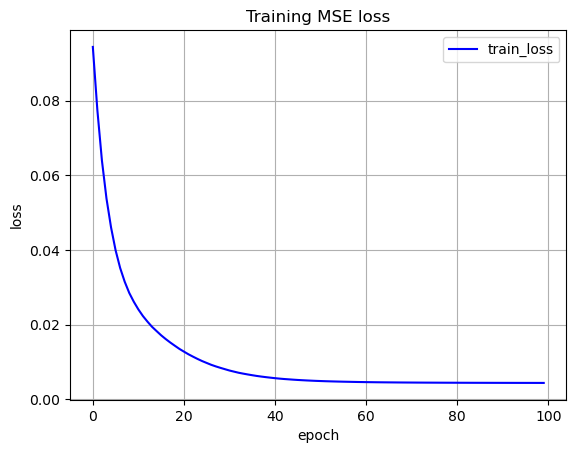

In [9]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
#plt.ylim([0.0,0.0001])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training MSE loss')
plt.grid()
plt.savefig('AE_iris_loss.png')
plt.show()

In [10]:
# ======== eval_mode (train samples) ======
net.eval()
train_fc1_features = np.zeros((len(X), n_hidden))
train_fc1_labels = np.zeros(len(X), dtype=int)

with torch.no_grad():
    i = 0
    for (xdata, tdata) in train_loader:        
        xdata = xdata.to(device)
        outputs = net.fc1(xdata)
        len_batch = len(xdata)
        train_fc1_features[i:i+len_batch] = outputs.cpu().detach().numpy()
        train_fc1_labels[i:i+len_batch] = tdata
        i += len_batch

print(train_fc1_features.shape)
print(train_fc1_labels.shape)

(150, 2)
(150,)


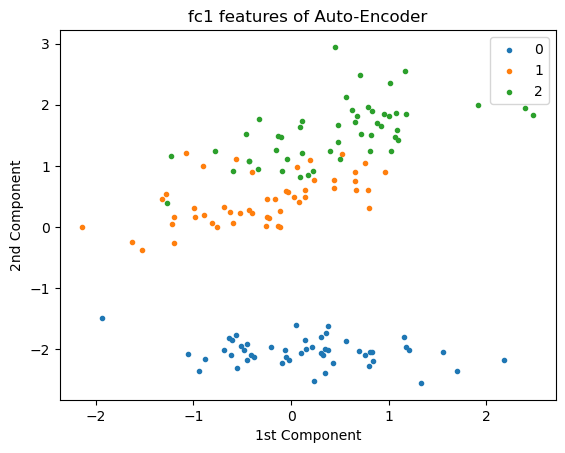

In [11]:
nclass = 3
#colors = np.random.rand(nclass) * 500000000000
colors = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']

## plot
plt.figure()
for k in range(nclass):
    plt.scatter(train_fc1_features[train_fc1_labels == k, 0], train_fc1_features[train_fc1_labels == k, 1], marker='.', label=k)
#plt.scatter(train_features[:, 0], train_features[:, 1], c=colors[train_labels], marker=".", label=colors)
plt.legend()
plt.title('fc1 features of Auto-Encoder')
plt.xlabel('1st Component')
plt.ylabel('2nd Component')
plt.savefig('AE_iris_train_fc1_features.png')
plt.show()

In [12]:
# PCA of original Features
from sklearn.decomposition import PCA

## PCA
pca = PCA(n_components=2)
#pca = PCA(n_components=2, svd_solver='randomized')
train_pca_score = pca.fit(X).transform(X)
#print(pca.singular_values_)
print('Explained Variance Ratio\n', pca.explained_variance_ratio_)


Explained Variance Ratio
 [0.72962446 0.22850761]


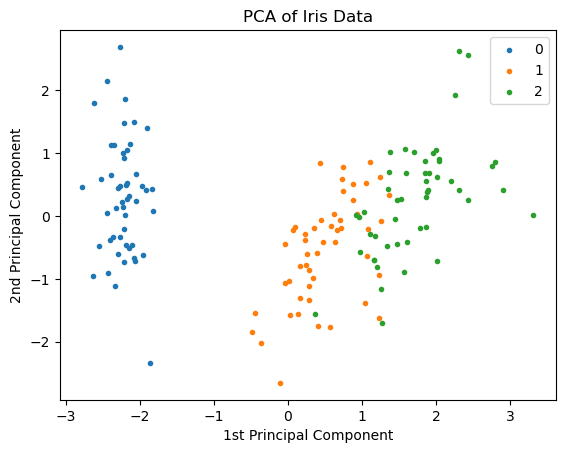

In [13]:
## plot
plt.figure()
for k in range(nclass):
    plt.scatter(train_pca_score[t == k, 0], train_pca_score[t == k, 1], marker='.', label=k)
#plt.scatter(train_features[:, 0], train_features[:, 1], c=colors[train_labels], marker=".", label=colors)
plt.legend()
plt.title('PCA of Iris Data')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.savefig('PCA_iris.png')
plt.show()

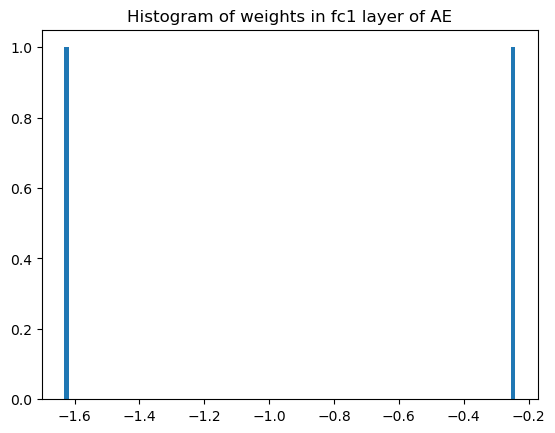

In [14]:
# Plot Histogram of hidden features

plt.hist(train_fc1_features[0], bins=100)
plt.title('Histogram of weights in fc1 layer of AE')
plt.savefig('AE_iris_fc1_features[0].png')
plt.show()

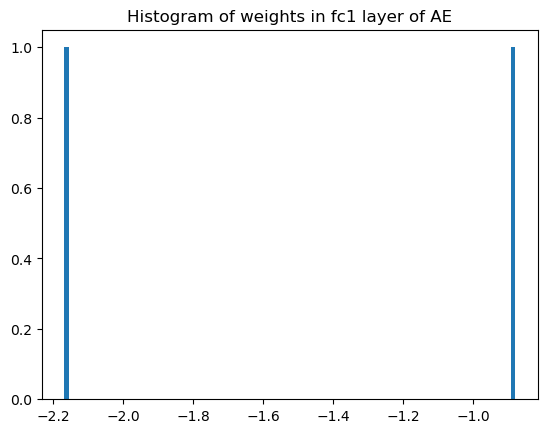

In [15]:
# Plot Histogram of hidden features

plt.hist(train_fc1_features[1], bins=100)
plt.title('Histogram of weights in fc1 layer of AE')
plt.savefig('AE_iris_fc1_features[1].png')
plt.show()